# Overview

This notebook is used to simply explore model output files at the moment.  It follows the style of `drb_make_figs.py`.

In [3]:
import os
os.getcwd()

'c:\\Users\\tjame\\Desktop\\Research\\DRB\\DRB_water_management\\notebooks'

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import gridspec
import datetime as dt
import sys
import h5py
import seaborn as sns

sys.path.append('../')

# Custom modules
from pywrdrb.utils.processing import get_base_results, get_pywr_results
from pywrdrb.plotting.plotting_functions import plot_3part_flows, plot_flow_contributions, plot_weekly_flow_distributions

In [5]:
### directories
output_dir = '../output_data/'
input_dir = '../input_data/'
fig_dir = '../figs/'

# Constants
cms_to_mgd = 22.82
cm_to_mg = 264.17/1e6
cfs_to_mgd = 0.0283 * 22824465.32 / 1e6


### list of reservoirs and major flow points to compare across models
reservoir_list = ['cannonsville', 'pepacton', 'neversink', 'wallenpaupack', 'prompton', 'shoholaMarsh', \
                   'mongaupeCombined', 'beltzvilleCombined', 'fewalter', 'merrillCreek', 'hopatcong', 'nockamixon', \
                   'assunpink', 'ontelaunee', 'stillCreek', 'blueMarsh', 'greenLane', 'marshCreek']
non_nyc_reservoirs = ['wallenpaupack', 'prompton', 'shoholaMarsh', \
                   'mongaupeCombined', 'beltzvilleCombined', 'fewalter', 'merrillCreek', 'hopatcong', 'nockamixon', \
                   'assunpink', 'ontelaunee', 'stillCreek', 'blueMarsh', 'greenLane', 'marshCreek']
trenton_reservoirs = ['wallenpaupack', 'prompton', 'shoholaMarsh', \
                   'mongaupeCombined', 'beltzvilleCombined', 'fewalter', 'merrillCreek', 'hopatcong', 'nockamixon', \
                   'assunpink']
majorflow_list = ['delLordville', 'delMontague', 'delTrenton', 'outletAssunpink', 'outletSchuylkill', 'outletChristina']

In [6]:
# Load pywr models
print('Retrieving simulation data.')
pywr_models = ['obs_pub', 'nhmv10', 'nwmv21']
res_releases = {}
major_flows = {}
inflows = {}
storages = {}

for model in pywr_models:
    res_releases[f'pywr_{model}'] = get_pywr_results(output_dir, model, 'res_release')
    major_flows[f'pywr_{model}'] = get_pywr_results(output_dir, model, 'major_flow')
    storages[f'pywr_{model}'] = get_pywr_results(output_dir, model, 'res_storage')
    inflows[model] = get_pywr_results(output_dir, model, 'inflow')
pywr_models = [f'pywr_{m}' for m in pywr_models]

# Load base (non-pywr) models
base_models = ['obs', 'obs_pub', 'nhmv10', 'nwmv21']
datetime_index = list(res_releases.values())[0].index
for model in base_models:
    res_releases[model] = get_base_results(input_dir, model, datetime_index, 'res_release')
    major_flows[model] = get_base_results(input_dir, model, datetime_index, 'major_flow')


Retrieving simulation data.


In [7]:
def get_simulated_FFMP_levels(output_dir, model, results_set='ffmp_levels', scenario=0):
    with h5py.File(f'{output_dir}drb_output_{model}.hdf5', 'r') as f:
        keys = list(f.keys())
        drought_level = f['drought_level_agg_nyc']
        results = pd.DataFrame(drought_level)
        day = [f['time'][i][0] for i in range(len(f['time']))]
        month = [f['time'][i][2] for i in range(len(f['time']))]
        year = [f['time'][i][3] for i in range(len(f['time']))]
        date = [f'{y}-{m}-{d}' for y, m, d in zip(year, month, day)]
        date = pd.to_datetime(date)
        results.index = date
    return results

In [8]:
start_date = '1999-10-01'
end_date = '2010-05-31'
d = get_simulated_FFMP_levels(output_dir, 'obs_pub').loc[start_date:end_date].values

In [9]:
def plot_combined_nyc_storage(results, models, 
                      start_date = '1999-10-01',
                      end_date = '2010-05-31',
                      use_percent = True,
                      plot_drought_levels = True, 
                      plot_historic_drought_points = True):
    """
    Plots of simulated & observed NYC combined reservoir storage.
    
    Parameters:
    results : dictionary of storage results from `get_pywr_results`
    models : list of models to plot
    reservoir_list : list of reservoirs to plot
    """
    colordict = {'obs_pub':'#097320', 'nhmv10': '#66c2a5', 'nwmv21': '#8da0cb', 'nwmv21_withLakes': '#8da0cb', 'WEAP_23Aug2022_gridmet': '#fc8d62',
                 'pywr_obs_pub':'#097320', 'pywr_nhmv10': '#66c2a5', 'pywr_nwmv21': '#8da0cb', 'pywr_nwmv21_withLakes': '#8da0cb',
                 'pywr_WEAP_23Aug2022_gridmet_nhmv10': '#fc8d62',
                 'historic': 'maroon'}

    ffmp_level_colors = ['blue', 'blue', 'blue', 'cornflowerblue', 'green', 'darkorange', 'maroon']
    drought_cmap = ListedColormap(ffmp_level_colors)

    reservoir_list = ['cannonsville', 'pepacton', 'neversink']
    capacities = {'cannonsville': 93000,
                  'pepacton': 140000,
                  'neversink': 34500,
                  'combined': 267500}
    
    historic_storage = pd.read_csv(f'../input_data/historic_storages/NYC_storage_daily_2000-2021.csv', sep=',', index_col=0)
    historic_storage.index = pd.to_datetime(historic_storage.index)
    historic_storage = historic_storage.loc[start_date:end_date]
    
    model_names = [m[5:] for m in pywr_models]
    drought_levels = pd.DataFrame(index= historic_storage.index, columns = model_names)
    for model in model_names:
        drought_levels[model] = get_simulated_FFMP_levels(output_dir, model).loc[start_date:end_date]
    drought_levels.index = pd.to_datetime(historic_storage.index)
    
    # Create figure with m subplots
    n_subplots = 2 # if plot_drought_levels else 1
    
    fig = plt.figure(figsize=(10, 5))
    gs = gridspec.GridSpec(nrows=n_subplots, ncols=2, width_ratios=[15, 1], height_ratios=[1, 3], wspace=0.05)

    # Plot drought levels
    if plot_drought_levels:
        ax1 = fig.add_subplot(gs[0, 0])
        ax_cbar = fig.add_subplot(gs[0, 1])
        sns.heatmap(drought_levels.transpose(), cmap = drought_cmap,  
                    ax = ax1,
                    cbar_ax = ax_cbar, cbar_kws = dict(use_gridspec=False))
        ax1.set_xticklabels([])
        ax1.set_xticks([])
        ax1.set_ylabel('FFMP Level', fontsize=12)

    # Plot combined storage
    ax2 = fig.add_subplot(gs[1, 0])
    for m in models:
        if use_percent:
            sim_data = results[m][reservoir_list].sum(axis=1).loc[start_date:end_date]/capacities['combined']*100
            hist_data = historic_storage.loc[start_date:end_date, 'Total']/capacities['combined']*100
            ylab = f'Combined NYC Reservoirs \n Percentage Useable Storage'
        else:
            sim_data = results[m][reservoir_list].sum(axis=1).loc[start_date:end_date]
            hist_data = historic_storage.loc[start_date:end_date, 'Total']
            ylab = f'Combined NYC Reservoir Storage (MG)'
        ax2.plot(sim_data, color=colordict[m], label=f'{m}')
    ax2.plot(hist_data, color=colordict['historic'], label=f'Observed')
    
    ax2.set_ylabel(ylab, fontsize = 12)
    ax2.set_xlabel('Date', fontsize = 12)
    ax2.yaxis.set_label_coords(-0.1, 0.5) # Set y-axis label position
    ax2.grid(True, which='major', axis='y')
    ax2.set_ylim([0, 110])
    plt.legend()
    plt.xlabel('Date')
    
    # Create colorbar outside of subplots
    if ax_cbar is not None:
        cbar = ax_cbar.collections[0].colorbar
        #cbar.ax.tick_params(labelsize=12)
        #cbar.ax.set_ylabel('FFMP Level', fontsize=12, rotation=270, labelpad=15)
        #cbar.ax.yaxis.set_label_coords(4.5, 0.5)

    plt.suptitle('Simulated & Observed Storage in Combined NYC Reservoirs')
    plt.show()
    return

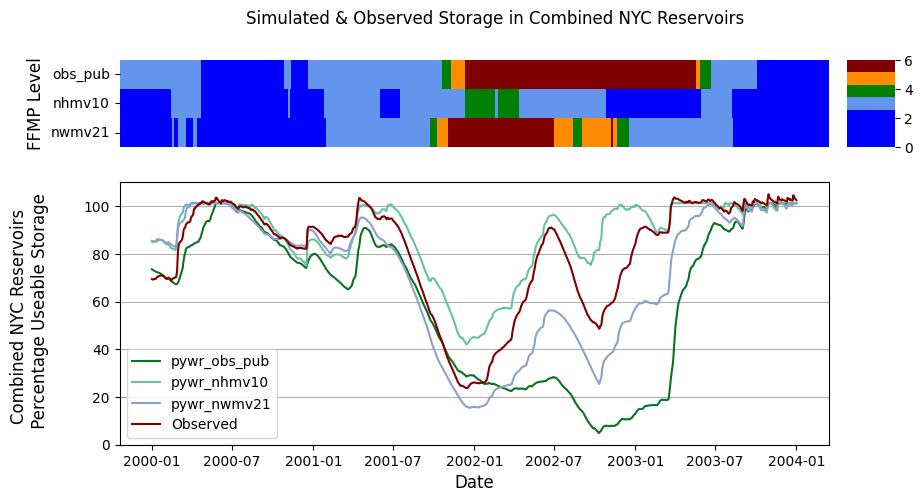

In [23]:
plot_combined_nyc_storage(storages, pywr_models, start_date='2000-01-01', end_date='2004-01-01')

Notice that the historic drought recovers quicker than the simulated storages.  Might this be due to the releases being reduced during this period beyond FFMP levels?


Text(0, 0.5, 'Combined NYC\n Reservoir Releases (MGD)')

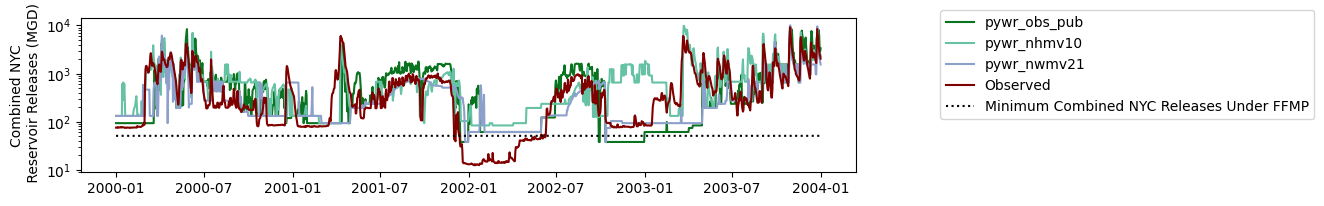

In [30]:
start_date='2000-01-01'
end_date = '2004-01-01'
min_ffmp_flow = 51.12
colordict = {'obs_pub':'#097320', 'nhmv10': '#66c2a5', 'nwmv21': '#8da0cb', 'nwmv21_withLakes': '#8da0cb', 'WEAP_23Aug2022_gridmet': '#fc8d62',
                'pywr_obs_pub':'#097320', 'pywr_nhmv10': '#66c2a5', 'pywr_nwmv21': '#8da0cb', 'pywr_nwmv21_withLakes': '#8da0cb',
                'pywr_WEAP_23Aug2022_gridmet_nhmv10': '#fc8d62',
                'historic': 'maroon'}

plt.figure(figsize=(10,2))
for model in pywr_models:
    plt.plot(res_releases[model].loc[start_date:end_date,:].index, res_releases[model].loc[start_date:end_date, ['cannonsville', 'neversink', 'pepacton']].sum(axis=1), label = model, color = colordict[model])
plt.plot(res_releases['obs'].loc[start_date:end_date,:].index, res_releases['obs'].loc[start_date:end_date, ['cannonsville', 'neversink', 'pepacton']].sum(axis=1), label = 'Observed', color = 'maroon')
plt.plot(res_releases['obs'].loc[start_date:end_date,:].index, np.ones(len(res_releases['obs'].loc[start_date:end_date,:].index))*min_ffmp_flow, label = 'Minimum Combined NYC Releases Under FFMP', color ='black', ls=':')
plt.yscale('log')
plt.legend(bbox_to_anchor = (1.1,1.1))
plt.ylabel('Combined NYC\n Reservoir Releases (MGD)')

In [16]:
res_releases['pywr_obs_pub'][['cannonsville', 'neversink', 'pepacton']].sum(axis=1)

1999-10-01    132.491175
1999-10-02    132.491175
1999-10-03    132.491175
1999-10-04    132.491175
1999-10-05    132.491175
                 ...    
2010-12-27    132.491175
2010-12-28    132.491175
2010-12-29    132.491175
2010-12-30    132.491175
2010-12-31    151.714672
Length: 4110, dtype: float64